# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, I used Python and OpenCV to find lane lines in the road images and videos.

The whole pipelines are as below:
- Gaussian Blur
- Color Selection
- Canny Edge Detection
- Region of Interest Selection
- Hough Transform Line Detection

The test images and video clips are:
- White lanes
- yelow lanes
- yellow lanes with shadow

First I tried in images and then video.The results are in ./test_videos

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Still have problems? Consult the forums and stackoverflow for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
import pandas as pd
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
import glob
import re
import collections

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


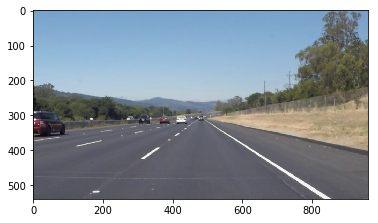

In [2]:
#reading in an image
image = mpimg.imread(r'.\test_images\solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Functions Samples

Below are some functions for reference

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


             
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def extract_video2jpeg(videofile,output_fold,end,start=0):
    """
        end: end time
        start:start time
    """
    clip=VideoFileClip(videofile).subclip()
    clip.write_images_sequence(output_fold+"image%03d.jpeg")
    

                        

## Test Images

Different lane types(yellow,white) and some challenging images extracted from video clips

Let's call `show_images_in_fold` to doubel check the images to be processed

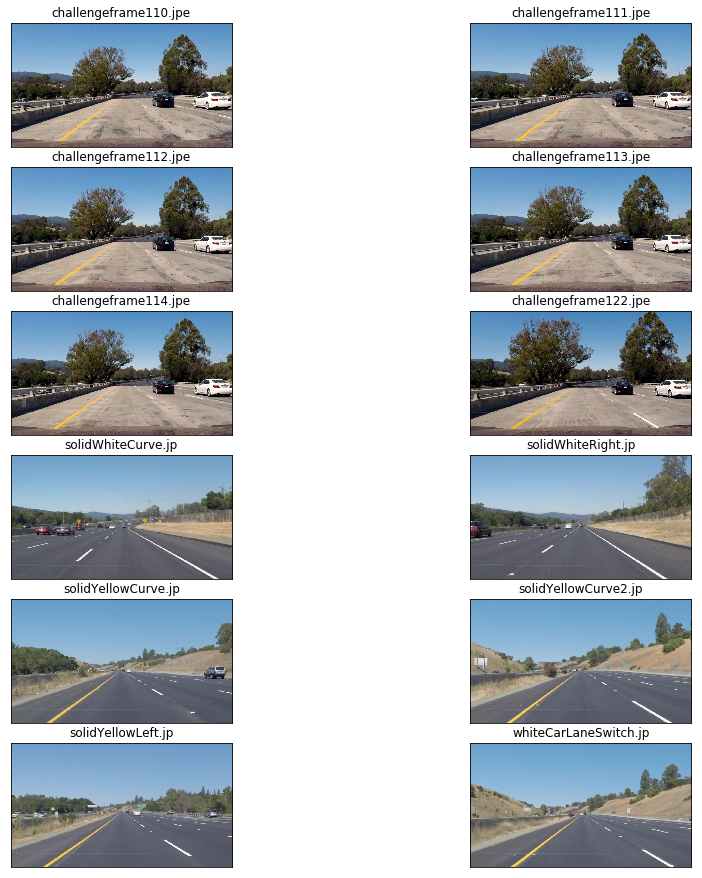

In [4]:
#images=[mpimg.imread(path) for path in glob.glob(r".\test_images\*.jp*")]
path ="./test_images"
def show_images_in_fold(path):
    glob_list=glob.glob(os.path.join(path, '*.jp*'))
    cols=2
    rows=int((len(glob_list)+1)/cols)
    plt.figure(figsize=(16,12)) 
    for i,file_name in enumerate(glob_list):
        image=mpimg.imread(file_name)
        plt.subplot(rows, cols, i+1)
        index = file_name.find("\\")
        plt.title(file_name[index+1:-1])
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

show_images_in_fold(path)


Lanes are yellow or white. Some are dot lines and some are solid lines.  

Load these images to be procssed.

In [5]:
images=[mpimg.imread(path) for path in glob.glob(r".\test_images\*.jp*")]
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

## Build a Lane Finding Pipeline
  - Load Image  
  - Color Slection  
  - Gray Image->Gaussian Denoise
  - Canny Edge Detection  
  - Region of Interest
  - Hough Line Detection           
  - Lines Processing to Extract Lanes  



Build the pipeline and run the solution on all test_images. Processed images in the `test_images_output` directory.

### Color Selection
cv2.cvtColor and cv2.inRange are used to select white and yellow.We have to decide which color space is good to seperate these two.The images are RGB color space.  Let's try selecting only yellow and white colors in the images under the RGB/HSL color space.The mask and the color space used in pipeline will be further tuned after integrating the full pipeline.

Reference:  
[Color picker, calculator and generator](http://www.colorizer.org/)  
[Color conversion](http://colormine.org/color-converter)  
[OpenCV Color Space examples](https://www.learnopencv.com/color-spaces-in-opencv-cpp-python/)

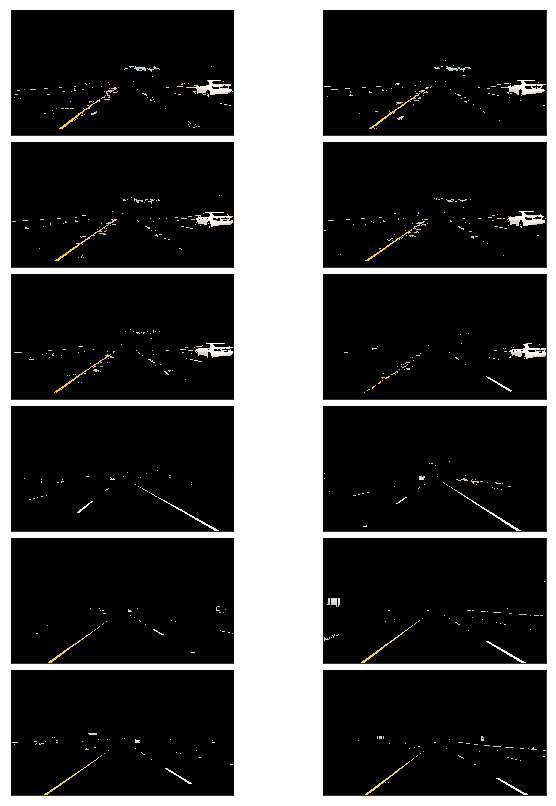

In [6]:
# image is expected be in RGB color space
def rgb_colorspace_white_yellow(image): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked
color_select=list(map(rgb_colorspace_white_yellow, images))
show_images(color_select)

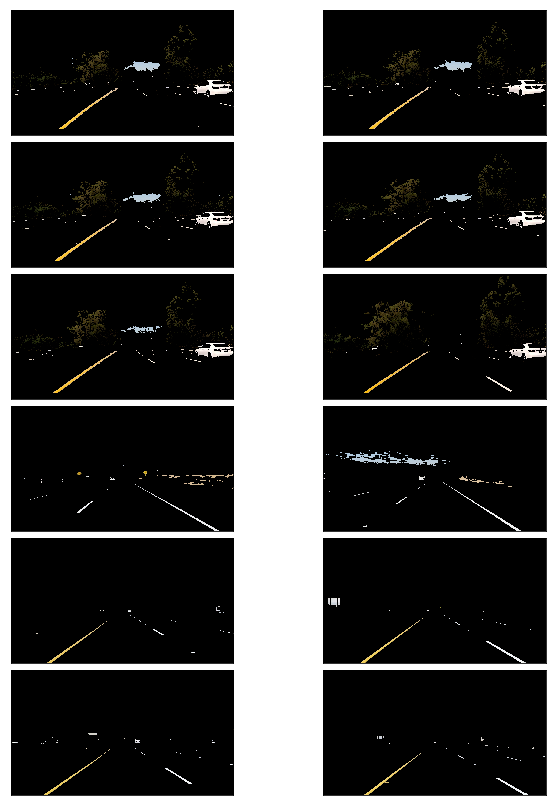

In [7]:
def HLS_colorspace_white_yellow(image):
    converted = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)
color_select=list(map(HLS_colorspace_white_yellow, images))
show_images(color_select)

### Image Preprocessing for Edge Detection
Here prepare the image for edge detection
- Use `cv2.cvtColor` to convert masked image to gray image.  
- Use `cv2.GaussianBlur` to smooth image. Kernel size needs to be tuned.


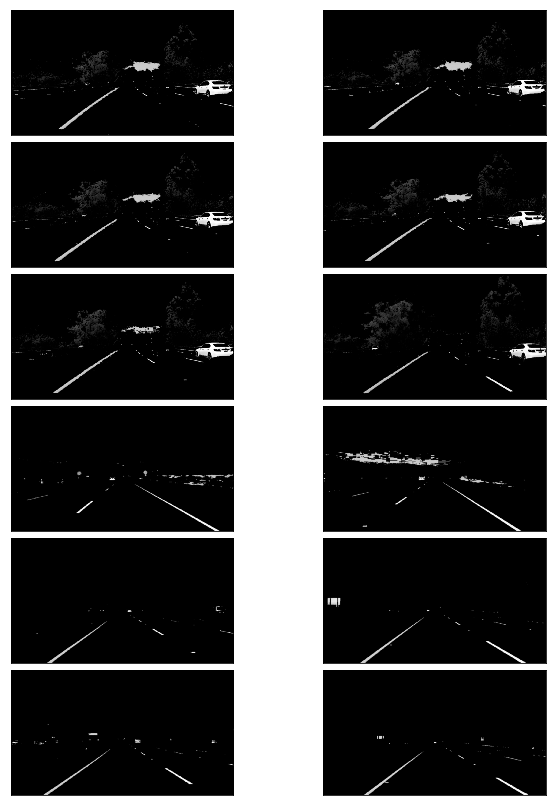

In [8]:
def smooth_image(image):
    converted = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(converted,(kernel_size, kernel_size),0)
    return blur_gray
blur_images=list(map(smooth_image, color_select))
show_images(blur_images)


### Edge Detection

`cv2.Canny` is used. The input is the image after color selection and smoothing. The low and high thresolds have to be tuned with the images. The thresolds will be better when the edges in lane lines are kept and other edges are minimal.
- [Canny Edge Detection OpenCV Theory](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html)
- [cv2.Canny OpenCV API Reference](http://docs.opencv.org/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html)

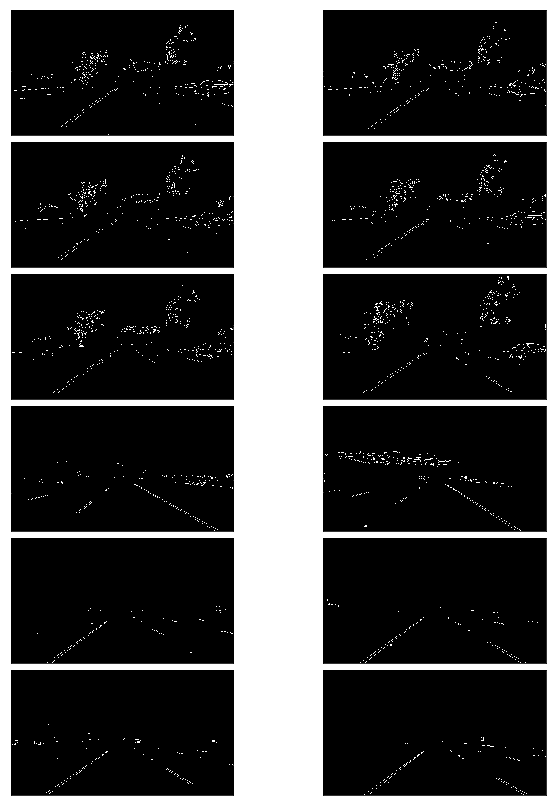

In [9]:
def detect_edges(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)
edge_images = list(map(detect_edges, blur_images))
show_images(edge_images)

### Region of Interest

`cv2.fillPoly` is used. The assumption is that camera is fixed on the car. So the view is almost fixed.


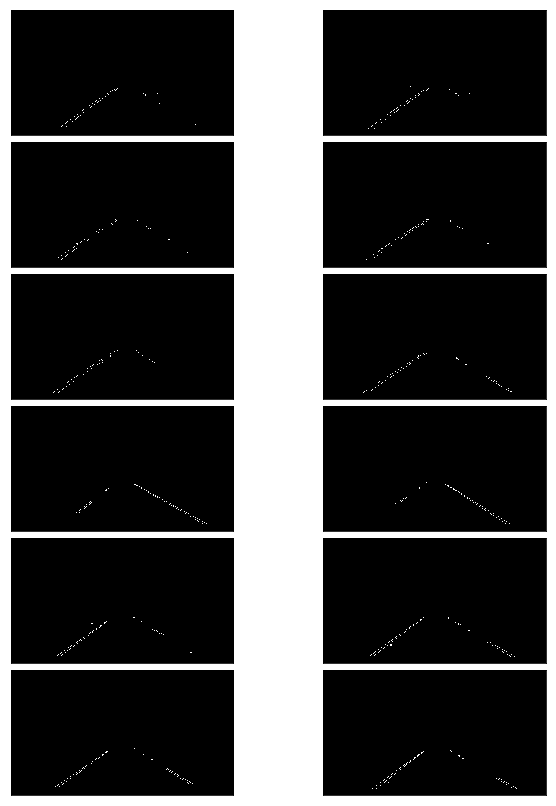

In [10]:
def ROI_mask_image(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    height,width = image.shape[:2]
    bottom_left  = [width*0.1, height*0.95]
    top_left     = [width*0.4, height*0.6]
    bottom_right = [width*0.9, height*0.95]
    top_right    = [width*0.6, height*0.6] 
    ignore_mask_color=255
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, vertices, ignore_mask_color)       
    return cv2.bitwise_and(image, mask)
ROI_mask_images = list(map(ROI_mask_image, edge_images))
show_images(ROI_mask_images)

### Hough Line Detection

The input to this function is the detected edges map.  
>`cv2.HoughLinesP`(masked_edges, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)
   - rho = 2 # distance resolution in pixels of the Hough grid
   - theta = np.pi/180 # angular resolution in radians of the Hough grid
   - threshold = 25    # minimum number of votes (intersections in Hough grid cell)
   - min_line_length = 15 #minimum number of pixels making up a line
   - max_line_gap = 25   # maximum gap in pixels between connectable line segments  
   Very good explantations from OpenCV
- [Hough Line Transform OpenCV Theory](http://docs.opencv.org/doc/tutorials/imgproc/imgtrans/hough_lines/hough_lines.html)
- [cv.HoughLinesP OpenCV API Reference](http://docs.opencv.org/modules/imgproc/doc/feature_detection.html?highlight=houghlinesp#houghlinesp)

In [25]:
def detect_lines(image,rho=2,theta=np.pi/180,threshold=25,min_line_length=10,max_line_gap=25):
    height, width = image.shape[:2]
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    return lines
lines= list(map(detect_lines, ROI_mask_images))

### Lines Process to Extract Road Lanes
The input to this function is the detected lines from Hough.   
>The idea of this alogrithm is as below:
   - sepeare line segments into left and right lines by slope
   - remove outlier lines based on median absolut difference of slope
   - caculate average slope and intrecept and weigh by line length for left and right lanes
   - choose y_min and y_max
   - Caculate x_min and x_max using average intercept,slope,y_min and y_max


In [12]:
def seperate_left_right_lines(lines):
    """
    since the original point is in left top,
    negative slope is left lines and positive slope is right lines 
    and vertical lines are not considered.
    """
    if len(lines)==0:
        return None
    negative_slopes=[]
    negative_lines=[]
    positive_slopes=[]
    positive_lines=[]
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1==x2:
                continue
            current_slope = (y2-y1)/(x2-x1)        
            # left line
            if current_slope < 0.0:
                negative_slopes.append(current_slope)
                negative_lines.append(line)
           # right line
            if current_slope > 0.0:        
                positive_slopes.append(current_slope)
                positive_lines.append(line) 
    return negative_slopes,negative_lines,positive_slopes,positive_lines



In [13]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.
    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.
    Returns:
    --------
        mask : A numobservations-length boolean array.
    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    points_np=np.array(points)
    if len(points_np.shape) == 1:
        points_np = points_np[:,None]
    median = np.median(points_np, axis=0)
    diff = np.sum((points_np - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh
def remove_outlier_lines(lines,slopes):
    """
    remove some lines which slopes are outliers
    """
    return  np.array(lines)[~is_outlier(slopes,1.4)].tolist()


In [14]:
def extract_lane(lines):
    if len(lines)==0:
        return None
    lines_temp=[]
    weights_temp=[]
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1==x2:
                continue #vertical line not considered
            slope=(y2-y1)/(x2-x1)
            intercept=y1-slope*x1
            length=np.sqrt((y2-y1)**2+(x2-x1)**2)
            lines_temp.append((slope,intercept))
            weights_temp.append((length))        
    #print("extract_lane:",lines_temp,weights_temp)  
    lane=np.dot(weights_temp,lines_temp)/np.sum(weights_temp) if len(weights_temp) >0 else None
    return lane

Integrate line processing into one function and draw

In [15]:
def convert_slop_intercept_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None 
    slope, intercept = line 
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)    
    return ((x1, y1), (x2, y2)) 

def convert_lanes_cvlines(img,left_lane,right_lane):
    #set y_min and y_max value
    y_max = img.shape[0]
    y_min = int(img.shape[0]*0.6)  
    left_line=convert_slop_intercept_points(y_min,y_max,left_lane)
    right_line=convert_slop_intercept_points(y_min,y_max,right_lane)
    return left_line,right_line    

def process_lines2lanes(img,lines):
    if len(lines)==0:
        return None
    #line_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    negative_slopes=[]
    negative_lines=[]
    positive_slopes=[]
    positive_lines=[]
    negative_slopes,negative_lines,positive_slopes,positive_lines=seperate_left_right_lines(lines)
    positive_lines_outlier_removed= remove_outlier_lines(positive_lines,positive_slopes)
    negative_lines_outlier_removed= remove_outlier_lines(negative_lines,negative_slopes)
    left_lane=extract_lane(negative_lines_outlier_removed) 
    right_lane=extract_lane(positive_lines_outlier_removed)
    left_line,right_line=convert_lanes_cvlines(img,left_lane,right_lane)
    return left_line,right_line
    


In [16]:
def draw_lanes(img,left_line,right_line):
    (left_x_min, y_min), (left_x_max, y_max)=left_line
    (right_x_min, y_min), (right_x_max, y_max)=right_line
    cv2.line(img, (left_x_min, y_min), (left_x_max, y_max), [255, 0, 0], 12) 
    cv2.line(img, (right_x_min, y_min), (right_x_max, y_max), [255, 0, 0], 12)
    
    '''
    #y_min,y_max,slope,intecpet to calculate x_min,x_max
    #X=(y-intercept)/slop
    slope,intercept=left_lane
    left_x_min=int((y_min-intercept)/slope)
    left_x_max=int((y_max-intercept)/slope)
    #5.2draw left line
    cv2.line(img, (left_x_min, y_min), (left_x_max, y_max), [255, 0, 0], 12) 
    
    slope,intercept=right_lane
    right_x_min=int((y_min-intercept)/slope)
    right_x_max=int((y_max-intercept)/slope)    
    #5.2draw right line
    cv2.line(img, (right_x_min, y_min), (right_x_max, y_max), [255, 0, 0], 12)       
    '''
  

### Pipeline Intergrated for One Frame
Below will integrare all the alogrithms for one image processing
    

In [17]:
def process_image(img):
    color_select=HLS_colorspace_white_yellow(img)
    gray=smooth_image(color_select)
    edges=detect_edges(gray)
    mask=ROI_mask_image(edges)  
       
    '''
    plt.figure(figsize=[8,6])
    plt.imshow(edges)
    plt.show()    
    '''
    
    masked_edges = cv2.bitwise_and(edges, mask)
    lines=detect_lines(masked_edges)
    
    '''
    plt.figure(figsize=[8,6])
    plt.imshow(masked_edges)
    plt.show()
    '''  
    #none handle
    if lines==None:
        return img
   
    # Create a "color" binary image to combine with line image
    line_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    left_line,right_line=process_lines2lanes(line_image,lines)
  
    #none handle
    if left_line==None:
        return img
    if right_line==None:
        return img
    #draw lanes
    draw_lanes(line_image, left_line,right_line)
    #Blending lanes with original image 
    lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)
    
    '''
    plt.figure(figsize=[8,6])
    plt.imshow(lines_edges)
    plt.show()
    '''
    return lines_edges


## Test on Images

Let's test the whole pipelines on the images and output the result to a PNG file.



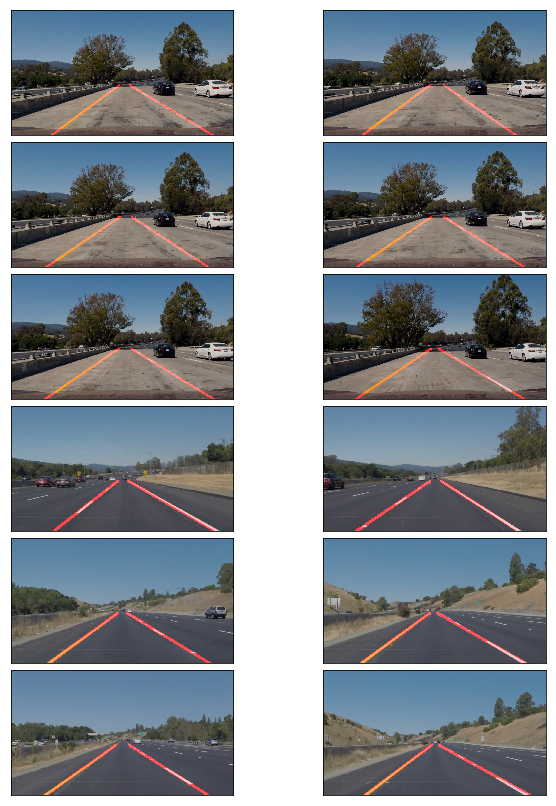

In [18]:
result_images = list(map(process_image, images))
show_images(result_images)

## Test on Videos

Drawing lanes over video! 
Unfortunately video flick happens.
Here we will apply lanes fading among frames through a frame queue

We test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4` 

`challenge.mp4` 


In [19]:
from collections import deque

QUEUE_LENGTH=10

class LaneDetector:
    def __init__(self):
        self.left_lines  = deque(maxlen=QUEUE_LENGTH)
        self.right_lines = deque(maxlen=QUEUE_LENGTH)

    def process(self, img):      
        color_select=HLS_colorspace_white_yellow(img)
        gray=smooth_image(color_select)
        edges=detect_edges(gray)
        mask=ROI_mask_image(edges)         
        masked_edges = cv2.bitwise_and(edges, mask)
        lines=detect_lines(masked_edges)
        #none handle
        if lines==None:
            return img
        # Create a "color" binary image to combine with line image
        line_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        left_line,right_line=process_lines2lanes(img,lines)
        

        def mean_line(line, lines):
            if line is not None:
                lines.append(line)

            if len(lines)>0:
                line = np.mean(lines, axis=0, dtype=np.int32)
                line = tuple(map(tuple, line)) # make sure it's tuples not numpy array for cv2.line to work
            return line

        left_line  = mean_line(left_line,  self.left_lines)
        right_line = mean_line(right_line, self.right_lines)
        
            #draw lanes
        draw_lanes(line_image, left_line,right_line)
        #Blending lanes with original image 
        lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0) 
        return lines_edges
        #return draw_lane_lines(image, (left_line, right_line))

In [20]:
def process_video(video_input, video_output):
    detector = LaneDetector()

    clip = VideoFileClip(os.path.join('test_videos', video_input))
    processed = clip.fl_image(detector.process)
    processed.write_videofile(os.path.join('output_videos', video_output), audio=False)

In [21]:
%time process_video('solidWhiteRight.mp4', 'white.mp4')    

[MoviePy] >>>> Building video output_videos\white.mp4
[MoviePy] Writing video output_videos\white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 32.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos\white.mp4 

Wall time: 8.03 s


In [22]:
%time process_video('solidYellowLeft.mp4', 'yellow.mp4') 


[MoviePy] >>>> Building video output_videos\yellow.mp4
[MoviePy] Writing video output_videos\yellow.mp4


100%|█████████▉| 681/682 [00:22<00:00, 30.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos\yellow.mp4 

Wall time: 23.7 s


In [23]:
%time process_video('challenge.mp4', 'challenge_out_1.mp4')

[MoviePy] >>>> Building video output_videos\challenge_out_1.mp4
[MoviePy] Writing video output_videos\challenge_out_1.mp4


100%|██████████| 251/251 [00:15<00:00, 15.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos\challenge_out_1.mp4 

Wall time: 18 s


Let's try the one with the solid white lane on the right first ...

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))